In [175]:
import requests
import numpy as np
from config import *
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import os
import json

from dateutil.relativedelta import relativedelta
from docopt import docopt #해당 모듈을 어떻게 쓸지 자동으로 알려 줌
from warnings import filterwarnings

filterwarnings('ignore')

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# font_path = "C:/Windows/Fonts/malgun.ttf"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
# plt.rcParams['axes.unicode_minus'] = False


In [4]:
def df_plotting(df, title='Insert Title'):

    column_idx = df.columns.to_list()
    time_idx = df.index.to_list()

    plt.figure(figsize=(14,8))
    
    for i in column_idx:
        plt.plot(time_idx, df[i], label=i)

    plt.title(title, size=30)
    plt.legend()
    plt.show()

In [5]:
def daily_news_df(date_from, date_to):
    
    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    #date_interval = list(pd.date_range(dt.datetime.strptime(date_from, '%Y-%m-%d'), dt.datetime.strptime(date_to, '%Y-%m-%d'), freq='d'))  

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_day = {
        "size": 0,
            "query":{
                "range":{
                "created_at": {
                    "gte": date_from,
                    "lte": date_to
                    }
                }
            },
            "aggs": {
                "group_by_date":{
                "date_histogram": {
                    "field": "created_at",
                    "interval": "day"
                }
            }
        }
    }

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=json.dumps(query_day),
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    daily = data['aggregations']['group_by_date']['buckets']
    df_daily = pd.DataFrame(data = daily)[['key_as_string', 'doc_count']]
    df_daily = df_daily.rename(columns={"key_as_string" : "date"})
    df_daily['date'] = pd.to_datetime(df_daily['date'])
    df_daily = df_daily.set_index('date')

    return df_daily

In [6]:
df = daily_news_df("2022-05-01", "2022-05-31")

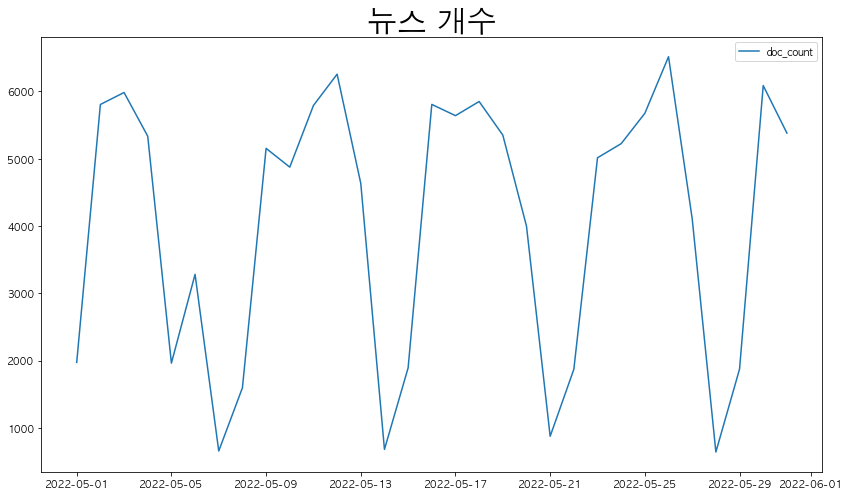

In [7]:
df_plotting(df, "뉴스 개수")

# 2. Top5 언론사 리스트 변수로 받아 각 날짜 별로 언론사 기사 갯수 time-series chart 출력

## Top5 언론사

In [8]:
def top_publisher(num_of_publisher, date_from, date_to):
    
    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_publisher = {
    "size": 0,
        "query":{
            "range":{
                "created_at": {
                    "gte": date_from,
                    "lte": date_to
                    }
                }
            },
    "aggs": {
        "group_by_publisher":{
            "terms": {
                "field": "publisher.keyword",
                "size": num_of_publisher
                }
            }
        }
    }

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=json.dumps(query_publisher),
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    dict = data['aggregations']['group_by_publisher']['buckets']

    df = pd.DataFrame(data=dict)

    # publisher_list = []
    # for i in range(len(dict)):
    #     publisher_list.append(dict[i]['key'])

    return df['key'].to_list()

In [9]:
top_publisher(5, "2022-05-01", "2022-05-31")

['뉴스1', '뉴시스', '연합뉴스', '이데일리', '파이낸셜뉴스']

In [10]:
def publisher_daily_news_trend (publisher_list, date_from, date_to):
    
    time_idx = daily_news_df(date_from, date_to).index.to_list()

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    df = pd.DataFrame(index=time_idx)

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    headers = {
    'Content-Type' : 'application/json'
    }


    for keyword in publisher_list:
        query = {
            "size": 0,
            "query":{
                "range":{
                    "created_at": {
                        "gte": date_from,
                        "lte": date_to
                        }
                    }
                },
                "aggs": {
                    "group_by_date":{
                        "date_histogram": {
                            "field": "created_at",
                            "interval": "day"
                        }
                    }
                },
                "query":{
                    "match":{
                    "publisher": keyword
                    }
                }
        }
        
        resp = requests.get(
            url,
            data=json.dumps(query),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()
        data = data['aggregations']['group_by_date']['buckets']
        df_tmp = pd.DataFrame(data = data)[['key_as_string', 'doc_count']]
        df_tmp = df_tmp.rename(columns={"key_as_string" : "date"})
        df_tmp['date'] = pd.to_datetime(df_tmp['date'])
        df_tmp = df_tmp.set_index('date')

        df[keyword] = df_tmp['doc_count']


    return df
    

In [11]:
publisher_daily_news_trend(top_publisher(5, "2022-05-01", "2022-05-31"), "2022-05-01", "2022-05-31")

,뉴스1,뉴시스,연합뉴스,이데일리,파이낸셜뉴스
2022-05-01 00:00:00+00:00,217,161,178,136,128
2022-05-02 00:00:00+00:00,471,500,406,443,353
2022-05-03 00:00:00+00:00,528,580,461,494,316
2022-05-04 00:00:00+00:00,501,403,403,400,293
2022-05-05 00:00:00+00:00,116,128,162,100,99
2022-05-06 00:00:00+00:00,279,284,263,278,123
2022-05-07 00:00:00+00:00,45,50,39,48,26
2022-05-08 00:00:00+00:00,104,103,125,89,110
2022-05-09 00:00:00+00:00,446,420,378,385,288
2022-05-10 00:00:00+00:00,390,393,375,414,287


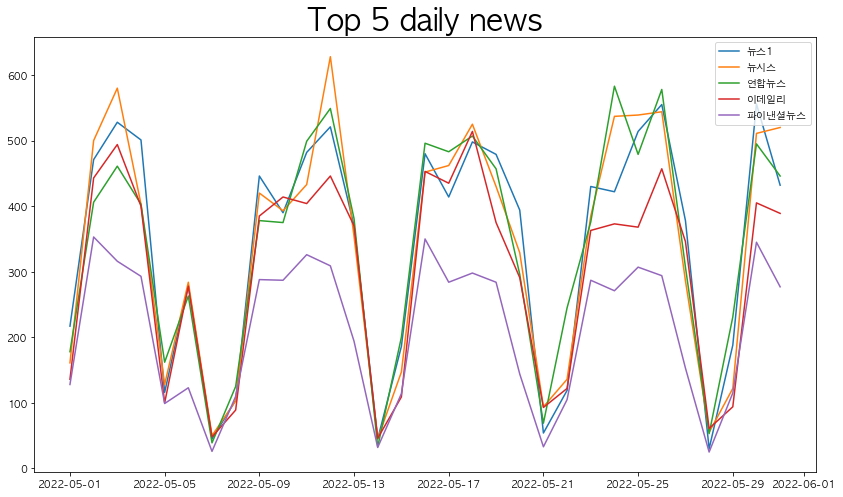

In [12]:
df_plotting(publisher_daily_news_trend(top_publisher(5, "2022-05-01", "2022-05-31"), "2022-05-01", "2022-05-31"),"Top 5 daily news")

# 3. 키워드 리스트를 변수로 받아 키워드별 일별 기사 갯수 & 비율 출력

In [36]:
def keyword_daily_news_trend (keyword_list, date_from, date_to):

    time_idx = daily_news_df(date_from, date_to).index.to_list()

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    df = pd.DataFrame(index=time_idx)

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    headers = {
    'Content-Type' : 'application/json'
    }


    for keyword in keyword_list:
        query = {
                "size": 0,
                    "query":{
                        "range":{
                        "created_at": {
                            "gte": date_from,
                            "lte": date_to
                            }
                        }
                },
                "aggs": {
                    "group_by_date":{
                        "date_histogram": {
                            "field": "created_at",
                            "interval": "day"
                        }
                    }
                },
                "query":{
                    "match":{
                    "body": keyword
                    }
                }
            }

        resp = requests.get(
            url,
            data=json.dumps(query),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()
        data = data['aggregations']['group_by_date']['buckets']
        df_tmp = pd.DataFrame(data = data)[['key_as_string', 'doc_count']]
        df_tmp = df_tmp.rename(columns={"key_as_string" : "date"})
        df_tmp['date'] = pd.to_datetime(df_tmp['date'])
        df_tmp = df_tmp.set_index('date')

        df[keyword] = df_tmp['doc_count']

    
    df = df.fillna(0)

    return df
    

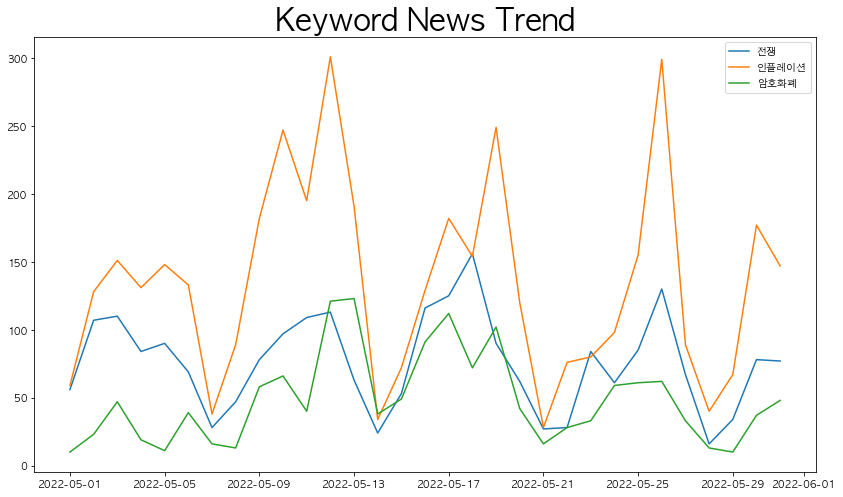

In [14]:
df_plotting(keyword_daily_news_trend(['전쟁', '인플레이션', '암호화폐'], "2022-05-01", "2022-05-31"), "Keyword News Trend")

In [139]:
keyword_daily_news_trend(port['종목명'].to_list(), "2022-05-01", "2022-05-31")

,셀트리온,삼성전자,신세계,흥국화재,효성,제주항공
2022-05-01 00:00:00+00:00,5,110,9,0,1,12
2022-05-02 00:00:00+00:00,7,205,26,1,2,14
2022-05-03 00:00:00+00:00,5,188,32,0,1,14
2022-05-04 00:00:00+00:00,9,252,26,1,0,12
2022-05-05 00:00:00+00:00,3,100,9,0,2,5
2022-05-06 00:00:00+00:00,26,137,22,0,4,3
2022-05-07 00:00:00+00:00,0,16,4,1,0,3
2022-05-08 00:00:00+00:00,0,66,5,0,0,12
2022-05-09 00:00:00+00:00,17,152,24,6,1,20
2022-05-10 00:00:00+00:00,13,251,47,5,16,6


In [15]:
keyword_daily_news_trend(['전쟁', '인플레이션', '암호화폐'], "2022-05-01", "2022-05-31")

,전쟁,인플레이션,암호화폐
2022-05-01 00:00:00+00:00,56,59,10
2022-05-02 00:00:00+00:00,107,128,23
2022-05-03 00:00:00+00:00,110,151,47
2022-05-04 00:00:00+00:00,84,131,19
2022-05-05 00:00:00+00:00,90,148,11
2022-05-06 00:00:00+00:00,69,133,39
2022-05-07 00:00:00+00:00,28,38,16
2022-05-08 00:00:00+00:00,47,89,13
2022-05-09 00:00:00+00:00,78,182,58
2022-05-10 00:00:00+00:00,97,247,66


# 4. 날짜별로 뉴스 Title 크롤링해서 리스트로 정리

In [16]:
def fetch_news_docs(date_from, date_to, page):
    
    date_from = date_from.isoformat()[0:10]
    date_to = date_to.isoformat()[0:10]

    query = {
        "query": {
            "range":{
                "created_at": {
                    "gte": date_from,
                    "lte": date_to
                }
            }
        },
        "size": 10,
        "from": page * 10
    }

    headers = {
        'Content-Type': 'application/json'
    }

    resp = requests.get(
        f'{ELASTIC_SEARCH_URL}/news/_search',
        headers = headers,
        data = json.dumps(query),
        auth = ELASTIC_SEARCH_AUTH
    )

    assert resp.status_code == 200

    data = json.loads(resp.text)
    hits = data['hits']['hits']

    return hits

def get_titles(hits):

    return hits['_source']['title']

def download_total_title (date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    print("Downloading data from OpenSearch server")

    total_title_list = []

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(f"{str_date} Start!")

        daily_title_list = []

        start_date = date_interval[i]
        end_date = date_interval[i] + relativedelta(days=1)

        for page in range(1000):

#            print('.', end='', flush=True)

            hits = fetch_news_docs(start_date, end_date, page)

            if len(hits) == 0:
                break

            for doc in hits:
            
                daily_title_list.append(get_titles(doc))

        total_title_list.append(daily_title_list)

        print("***" + str_date + "End!" + "***")

    print("Daily Data end!")

    return total_title_list

def total_title_show (total_title_list, date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(str_date)
        print(total_title_list[i] + '\n')

    #return date_interval

def txt_title_save (total_title_list, date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    with open('title_list_allday.txt','w',encoding='UTF-8') as f:

        for i in range(len(total_title_list)):
        
            str_date = date_interval[i].strftime('%Y-%m-%d')

            f.write('\n' + '[' + str_date + ']' + '\n\n')
        
            for titles in total_title_list[i]:

                f.write(titles + '\n')

In [156]:
def fetch_news_docs(date_from, date_to, page):
    
    date_from = date_from.isoformat()[0:10]
    date_to = date_to.isoformat()[0:10]

    query = {
        "query": {
            "range":{
                "created_at": {
                    "gte": date_from,
                    "lte": date_to
                }
            }
        },
        "size": 10,
        "from": page * 10
    }

    headers = {
        'Content-Type': 'application/json'
    }

    resp = requests.get(
        f'{ELASTIC_SEARCH_URL}/news/_search',
        headers = headers,
        data = json.dumps(query),
        auth = ELASTIC_SEARCH_AUTH
    )

    assert resp.status_code == 200

    data = json.loads(resp.text)
    hits = data['hits']['hits']

    return hits

def get_titles(hits):

    return hits['_source']['title']

def download_total_title (date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    print("Downloading data from OpenSearch server")

    total_title_list = []

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(f"{str_date} Start!")

        daily_title_list = []

        start_date = date_interval[i]
        end_date = date_interval[i] + relativedelta(days=1)

        for page in range(1000):

#            print('.', end='', flush=True)

            hits = fetch_news_docs(start_date, end_date, page)

            if len(hits) == 0:
                break

            for doc in hits:
            
                daily_title_list.append(get_titles(doc))

        total_title_list.append(daily_title_list)

        print("***" + str_date + "End!" + "***")

    print("Daily Data end!")

    return total_title_list

def total_title_show (total_title_list, date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(str_date)
        print(total_title_list[i] + '\n')

    #return date_interval

def txt_title_save (total_title_list, date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    with open('title_list_allday.txt','w',encoding='UTF-8') as f:

        for i in range(len(total_title_list)):
        
            str_date = date_interval[i].strftime('%Y-%m-%d')

            f.write('\n' + '[' + str_date + ']' + '\n\n')
        
            for titles in total_title_list[i]:

                f.write(titles + '\n')

In [93]:
#daily_news_title = download_total_title('2022-05-01', '2022-05-31')

2022-05-01 Start!
***2022-05-01End!***
2022-05-02 Start!
***2022-05-02End!***
2022-05-03 Start!
***2022-05-03End!***
2022-05-04 Start!
***2022-05-04End!***
2022-05-05 Start!
***2022-05-05End!***
2022-05-06 Start!
***2022-05-06End!***
2022-05-07 Start!
***2022-05-07End!***
2022-05-08 Start!
***2022-05-08End!***
2022-05-09 Start!
***2022-05-09End!***
2022-05-10 Start!
***2022-05-10End!***
2022-05-11 Start!
***2022-05-11End!***
2022-05-12 Start!
***2022-05-12End!***
2022-05-13 Start!
***2022-05-13End!***
2022-05-14 Start!
***2022-05-14End!***
2022-05-15 Start!
***2022-05-15End!***
2022-05-16 Start!
***2022-05-16End!***
2022-05-17 Start!
***2022-05-17End!***
2022-05-18 Start!
***2022-05-18End!***
2022-05-19 Start!
***2022-05-19End!***
2022-05-20 Start!
***2022-05-20End!***
2022-05-21 Start!
***2022-05-21End!***
2022-05-22 Start!
***2022-05-22End!***
2022-05-23 Start!
***2022-05-23End!***
2022-05-24 Start!
***2022-05-24End!***
2022-05-25 Start!
***2022-05-25End!***
2022-05-26 Start!
***2022

In [94]:
#daily_news_title

[['`그린 파이낸싱` 잰걸음...한국씨티은행 ESG 행보',
  '아시아나항공, 게이트 그룹 고소…"기내식 독점 공급권 헐값"',
  "[포커스] 위기의 한국 반도체…대만은 약진, 韓은 '빨간불'",
  '인덱스핑거, 학교 커뮤니티 플랫폼 ‘지금우리’ 선보여',
  '암초 만난 ‘망 사용료 의무화 법안’ [경제 블로그]',
  "로봇 동료와 함께 일하는 시대 개막...택배·소독·요리도 '척척'",
  '부산시, 롯데타워 경관심의 유보…임시사용 연장 위태',
  '초·중·고교 도보권 ‘창원 롯데캐슬 어반포레’',
  "무면허 고교생 훔친차 몰다 사고낸 뒤 도주…동승자 '의식불명'",
  '네스프레소, 커피 한 잔으로 파리·이스탄불·리우데자이네루를',
  '“5월 말까지 양도세 신고·납부하세요”',
  '유류세 인하 30% 확대 첫날..."가격은 그대로?"',
  '대출금, 더 길게 빌려드립니다',
  'LG이노텍 이역상씨, 근로자의 날 ‘금탑산업훈장’',
  '10곳중 6곳 기대이상 실적…2분기는 안갯속',
  '신문·달러 윤전기 형상화한 서울머니쇼 NFT 소장하세요',
  '아시아나항공, 기내식 공급사 경영진 고소…"박삼구 배임 공모"',
  '‘횡령’ 우리은행 직원, 검거 전 해외송금 시도…동생도 구속',
  'HDC현산, 이문3구역 시공권 유지…"시공권 배제 투표 부결"',
  '증시 덮친 인플레 공포… "실적·식음료·리츠가 피난처"',
  '코스닥 60개사 투자 주의 ‘환기종목’ 지정',
  '애플, 단기 실적 우려에도…"아이폰이 주가 끌어 올릴 것"',
  '[EcoKnow] 국화와 칼',
  "'유류세 인하 30% 확대' 첫날…체감 효과 얼마나?",
  '한전-포스코홀딩스-롯데케미칼, 수소·암모니아 사업 협력',
  'GS칼텍스·포스코인터 ‘친환경 바이오사업’ 강화',
  '‘매일 5만 톤’ 한강물로 전력 만들어 친환경 냉난방',
  '유류세 인하했다는데…우리동네 주유소 기름값 그대로인 이유는',
  '10년간 나눠 갚는 신용대출 출시... DSR에

In [95]:
#txt_title_save(daily_news_title, '2022-05-01', '2022-05-31')

In [172]:
def fetch_news_docs_keyword(date_from, date_to, page, keyword):
    
    date_from = date_from.isoformat()[0:10]
    date_to = date_to.isoformat()[0:10]

    query = {
        "query": {
            "bool": {
                "must":[
                    {
                        "match":{
                            "body": keyword
                        }
                    },
                    {
                    "range":{
                        "created_at": {
                            "gte": date_from,
                            "lt": date_to
                            }
                        }
                    }
                ]
            },
        },
        "size": 10,
        "from": page * 10
    }

    headers = {
        'Content-Type': 'application/json'
    }

    resp = requests.get(
        f'{ELASTIC_SEARCH_URL}/news/_search',
        headers = headers,
        data = json.dumps(query),
        auth = ELASTIC_SEARCH_AUTH
    )

    assert resp.status_code == 200

    data = json.loads(resp.text)
    hits = data['hits']['hits']

    return hits

def get_bodies(hits):

    return hits['_source']['body']


def download_total_title_keyword (date_from, date_to, keyword):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    print("Downloading data from OpenSearch server")

    total_title_list = []

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(f"{str_date} Start!")

        daily_title_list = []

        start_date = date_interval[i]
        end_date = date_interval[i] + relativedelta(days=1)

        for page in range(1000):

#            print('.', end='', flush=True)

            hits = fetch_news_docs_keyword(start_date, end_date, page, keyword)

            if len(hits) == 0:
                break

            for doc in hits:
            
                daily_title_list.append(get_titles(doc))

        total_title_list.append(daily_title_list)

        print("***" + str_date + "End!" + "***")

    print("Daily Data end!")

    return total_title_list


In [176]:
key_list = download_total_title_keyword('2022-05-01', '2022-05-01', "삼성전자")

2022-05-01 Start!
***2022-05-01End!***
Daily Data end!


In [177]:
key_list

[['삼성전자 상반기 C랩 스핀오프 론칭데이',
  "'성공을 기원합니다'",
  "'필로토' 창업자 응원하는 박학규 사장",
  '삼성전자, 상반기 C랩 스핀오프 론칭데이',
  "삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원",
  "삼성전자, 에버랜드서 3년만에 오프라인 '갤럭시 팬파티'",
  '대-중소기업 임금 양극화 심한데…삼성전자 노조 “돈 더 달라” 몽니',
  '웨이퍼 들었던 바이든, 삼성 반도체 공장 방문하나…기대감↑',
  '삼성전자, AI 온라인 시험 감독 등 에듀테크 스타트업 창업 지원',
  "삼성, 모바일 AP 점유율 '반토막'…파운드리도 18%서 정체",
  'AI로 온라인 시험 부정 잡는다..삼성이 지원하는 사내벤처는?',
  "삼성전자, hy·삼성카드와 '비스포크 큐커' 할인행사",
  '"AI가 시험 감독"…삼성전자, 사내벤처 2곳 \'픽\'',
  "삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인",
  "삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인",
  "삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인",
  "삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인",
  "삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원",
  "삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원",
  '韓 반도체, “공급망 재편서 살아남으려면 美 동맹 참여해야”',
  '삼성전자, `우리집 전자레인지, 큐커로 교체해요` 2차 캠페인 진행…hy와 협업',
  '‘지역화폐 지원’ 삼성페이, 지역경제 활성화 나선다',
  "삼성전자 파운드리 출범 5년…공존하는 '기회와 위기'",
  "삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원",
  '"三電, 이재용 부회장 빈자리 크다"…커지는 사면복권 목소리',
  '삼성전자, 에듀테크 관련 C랩 과제 2개 스타트업 창업 지원',
  "에버랜드에 모인 '갤럭시 찐팬들'

# 각 날짜별로 주요 이슈 Top 3 요약

In [148]:
import nltk
import datetime as dt
import pdb

from collections import defaultdict
from sklearn.pipeline import Pipeline

from es_corpus_reader import EsCorpusReader
from korean_text_normalizer import KoreanTextNormalizer
from gensim_vectorizer import GensimTfidVectorizer
    
def classification_top_n(count_dict, n=3):
    
    for group in range(len(count_dict)):
        count_dict[group].sort()

    top_n = dict(sorted(count_dict.items(), reverse=True, key=lambda x: len(x[1]))[:n])

    i = 1

    for key in top_n.keys():
    
        print(f"*** TOP {i} Section ***")
        
        for idx, content in enumerate(top_n[key]):
            
            if idx < 5:
                print(f"{content}")
            else:
                pass
        i += 1

def classification_top_1(count_dict, n=1):
    
    for group in range(len(count_dict)):
        count_dict[group].sort()

    top_n = dict(sorted(count_dict.items(), reverse=True, key=lambda x: len(x[1]))[:n])

    i = 1

    for key in top_n.keys():
        
        for idx, content in enumerate(top_n[key]):
            
            if idx < 5:
                print(f"{content}")
            else:
                pass
        i += 1

def daily_k_means_top3(date_from, date_to):

    date_from = (dt.datetime.strptime(date_from, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]
    date_to = (dt.datetime.strptime(date_to, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    total_doc_count = daily_news_df(date_from, date_to)

    for time in date_interval:

        str_time = time.strftime('%Y-%m-%d')

        reader = EsCorpusReader(date_from=time, date_to=time+dt.timedelta(days=1))

        doc_num = total_doc_count.loc[time]['doc_count']
 
        corpus = list(reader.titles(n=doc_num))


        model = Pipeline([
            ('normalizer', KoreanTextNormalizer()),
            ('vectorizer', GensimTfidVectorizer())
        ])

        vectors = model.fit_transform(corpus)

        num_means = 20
        distance = nltk.cluster.cosine_distance

        kmeans = nltk.cluster.KMeansClusterer(
            num_means=num_means,
            distance=distance,
            avoid_empty_clusters=True
        )

        kmeans.cluster(vectors)

        classified = defaultdict(list)

        for doc, vec in zip(corpus, vectors):
            group = kmeans.classify(vec)
            mean = kmeans.means()[group]
            dist = distance(vec, mean)

            entry = (dist, doc)

            classified[group].append(entry)

        print(f"-------- {str_time}'s TOP 3 ISSUES --------")
        classification_top_n(classified, n=3)
        print("\n")
        
        # for group in range(len(classified)):
        #     print(f'*** Group {group} ***')

        #     classified[group].sort() #작은거에서 큰걸로 그룹안에 점수 정렬함 (양극단값이 아래로 내려가고 중앙값이 가운데로 올라옴)

        #     print("Topic Size: {}".format(len(classified[group])))

        #     for idx, x in enumerate(classified[group]):
        #         print(f'{idx}: {x}')

        #         if idx > 5:
        #             break

        #     print()

    # return classified



In [178]:
daily_k_means_top3('2022-05-01', '2022-05-31')

-------- 2022-05-01's TOP 3 ISSUES --------
*** TOP 1 Section ***
(0.6707247189790515, "현대건설, '1조원 규모' 과천 주공8·9단지 재건축 사업 수주")
(0.671893621597563, '현대건설, 1조원 규모 과천 주공8·9단지 재건축 수주')
(0.671893621597563, '현대건설, 1조원 규모 과천 주공8·9단지 재건축 수주')
(0.6794502881212452, "삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원")
(0.6794502881212452, "삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원")
*** TOP 2 Section ***
(0.5439376712452549, "코스닥 주간 개인 순매도 1위 '셀트리온헬스케어'")
(0.5930377519283777, "코스피 주간 외국인 순매도 1위 '삼성전자'")
(0.59554232960457, '[표]주간?코스닥 기관·외국인·개인 순매수·순매도 상위종목(4월 25일~29일)')
(0.6127875868085926, '코스닥 주간 외국인 순매도 1위 ‘오스템임플란트’')
(0.6216125987069633, "코스피 주간 개인 순매도 1위 '기아'")
*** TOP 3 Section ***
(0.576822100448311, '한 달 만에 또 상승한 도시가스 요금')
(0.6416715244291771, '4월에 이어 5월에도 상승한 도시가스 요금')
(0.6541412721289181, "'또 상승하는 도시가스 요금'")
(0.6702000102870971, '상승한 도시가스 요금')
(0.6705334747633324, '한 달 만에 또 오른 도시가스 요금')


-------- 2022-05-02's TOP 3 ISSUES --------
*** TOP 1 Section ***
(0.6385207837059517, "삼성전자, '이음 5G' 전용 장비 출시")
(0.63852

# 키워드 날짜 별로 주요 이슈 요약

In [24]:
from es_corpus_reader_keyword import EsCorpusReader_key

In [42]:
a = keyword_daily_news_trend(["인플레이션"], "2022-05-01", "2022-05-01")

In [150]:
from es_corpus_reader_keyword import EsCorpusReader_key

def daily_k_means_top_keyword(date_from, date_to, keyword):

    date_from = (dt.datetime.strptime(date_from, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]
    date_to = (dt.datetime.strptime(date_to, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    total_doc_count = keyword_daily_news_trend([keyword], date_from, date_to)

    for time in date_interval:

        str_time = time.strftime('%Y-%m-%d')

        reader = EsCorpusReader_key(date_from=time, date_to = time+dt.timedelta(days=1), keyword=keyword)

        doc_num = total_doc_count.loc[time][total_doc_count.columns[0]]
 
        corpus = list(reader.titles(n=doc_num))

        model = Pipeline([
            ('normalizer', KoreanTextNormalizer()),
            ('vectorizer', GensimTfidVectorizer())
        ])

        vectors = model.fit_transform(corpus)

        num_means = 8
        distance = nltk.cluster.cosine_distance

        kmeans = nltk.cluster.KMeansClusterer(
            num_means=num_means,
            distance=distance,
            avoid_empty_clusters=True
        )

        kmeans.cluster(vectors)

        classified = defaultdict(list)

        for doc, vec in zip(corpus, vectors):
            group = kmeans.classify(vec)
            mean = kmeans.means()[group]
            dist = distance(vec, mean)

            entry = (dist, doc)

            classified[group].append(entry)

        print(f'''-------- {str_time}'s TOP ISSUE FOR "{keyword}" --------''')
        classification_top_1(classified, n=1)
        print("\n")

In [151]:
daily_k_means_top_keyword("2022-05-01", "2022-05-31", "인플레이션")

-------- 2022-05-01's TOP ISSUE FOR "인플레이션" --------
(0.5855423481140307, "에너지·곡물·광물 가격 다 올라…무역수지 만성적자 '경고등'")
(0.5855423481140307, '에너지·곡물·광물 가격 다 올라…무역수지 만성적자 ‘경고등’')
(0.6415752235032115, '원자재값 급등에 무역수지 또 적자')
(0.6500599128860601, "'쌍둥이 적자' 현실화 되나…고물가에 또 2개월 연속 무역적자")
(0.6554671926711853, "'무역적자 고착화' 우려…에너지價 고공행진에 무역수지 직격탄")


-------- 2022-05-02's TOP ISSUE FOR "인플레이션" --------
(0.5203719935614031, '신한자산운용, 얼리버드펀드 2년 누적 수익률 82.7%')
(0.5203719935614031, '신한자산운용, 얼리버드펀드 2년 누적 수익률 82.7%')
(0.5770648145082566, "신한자산운용 '얼리버드 펀드', 2년 누적 수익률 82%")
(0.601622302516932, '신한자산운용, 신한얼리버드 펀드 2년 누적 수익률 82% 성과')
(0.6558602111177309, '한국 경제 3% 성장 멀어지나...꽁꽁 언 소비·투자로 1분기 성장률 0.7%')


-------- 2022-05-03's TOP ISSUE FOR "인플레이션" --------
(0.5773008639363926, '물가 5% 위협하고 기대인플레 3%대…커지는 기준금리 인상 압박')
(0.5773008639363926, '물가 5% 위협하고 기대인플레 3%대…커지는 기준금리 인상 압박')
(0.6670948502228076, '물가 폭탄에 美 빅스텝까지...한은 연속 금리 인상 가능성 커졌다')
(0.6832924304204266, 'IMF부총재 "인플레, 각국 중앙은행 예상보다 더 빠를 수 있어"')
(0.6880599793590771, '"아직 아

In [152]:
daily_k_means_top_keyword("2022-05-01", "2022-05-31", "전쟁")

-------- 2022-05-01's TOP ISSUE FOR "전쟁" --------
(0.486914499391239, '오늘부터 휘발유 값 리터당 83원 더 내린다…유류세 30% 인하')
(0.504222218530786, '오늘부터 유류세 30% 인하…휘발유 값 리터당 83원 내린다')
(0.5596341776210103, '오늘부터 유류세 더 깎아준다...휘발유 최대 83원↓')
(0.6529579440104689, '휘발유 ℓ당 83원 내린다…알뜰·직영주유소부터 즉각 적용')
(0.6569458750563444, "하락장, 급증하는 공매도에 커지는 '개미비명'")


-------- 2022-05-02's TOP ISSUE FOR "전쟁" --------
(0.39084885064774566, '코로나 이전 실적 회복한 대기업…불확실성에 투자 미루고 현금 쌓아')
(0.3962631674033553, '대기업 실적 코로나 전 회복했지만…불확실성에 현금 쌓고 투자 미뤄')
(0.46976191266902234, '"100대 기업 실적 좋지만 투자 미루고 현금만 축적"')
(0.48670937532056313, '100대 기업, 코로나 이전 수준 실적 회복했지만…빚 내서 현금 충전에 집중')
(0.4956474018375724, '"100대 기업, 코로나19 이전 실적 회복했지만 빚내서 현금 축적"')


-------- 2022-05-03's TOP ISSUE FOR "전쟁" --------
(0.2362026424216429, '한은 “원자재가격·거리두기 해제로 당분간 4%대 물가 지속”')
(0.27049625190072213, '한은 "물가, 당분간 4%대 오름세 지속"')
(0.2738750939626805, '한은 "원자재가격·거리두기 해제로 당분간 물가상승률 4%대"')
(0.2738750939626805, '한은 "원자재가격·거리두기 해제로 당분간 물가상승률 4%대"')
(0.2952052981628761, '한은 "원자재가격 상승·거리

In [153]:
daily_k_means_top_keyword("2022-05-01", "2022-05-31", "암호화폐")

-------- 2022-05-01's TOP ISSUE FOR "암호화폐" --------
(0.27984203210564995, "업비트만 쓴다고?…코인 거래소 '마이너스 수수료' 유혹")
(0.2804540559656692, "카카오 '코인` 클레이튼, 최근 급락한 이유는?")


-------- 2022-05-02's TOP ISSUE FOR "암호화폐" --------
(0.23595902401950197, '빗썸, 돈워크맨과 굿네이버스에 기부금 전달')
(0.2483671605105282, '빗썸, 웹예능 ‘돈워크맨’과 굿네이버스에 기부금 전달')
(0.43144045833312084, '빗썸, 굿네이버스에 후원금 전달…“아이들의 꿈을 응원합니다”')
(0.6177246326137995, '\'비트코인 구세주\' 로저 버 "머스크의 트위터 인수는 신의 한 수"')
(0.645515176405302, '셀럽(CELEB), 더 샌드박스 내 한국복합문화공간 사업 참여')


-------- 2022-05-03's TOP ISSUE FOR "암호화폐" --------
(0.29815797374836084, "워런 버핏 vs 일론 머스크 '가상자산 시장 전망 승자는?'")
(0.4029578371026826, "'엇갈리는 가상자산 시장 전망…최후의 승자는?'")
(0.41581105245161654, "워런 버핏 vs 일론 머스크 '가상자산 시장 전망 놓고 이견'")
(0.42541801629785736, "'엇갈리는 가상자산 시장 전망'")
(0.4637817818117351, "'가상자산 시장 놓고 평가 엇갈리는 워런 버핏과 일론 머스크'")


-------- 2022-05-04's TOP ISSUE FOR "암호화폐" --------
(0.46447733177489003, 'FOMC 앞두고 차익실현 나선 듯…암호화폐 일제 하락(종합)')
(0.4819229397571215, "지난해 500대 기업 순위 변동…'배터리·암호화폐' 뜨고 '항공·유통' 졌다

# My Portfolio

In [104]:
# 코스닥, 코스피 종목코드 yf에서 추출
import pandas as pd
import FinanceDataReader as fdr
import yfinance as yf

from dateutil.relativedelta import relativedelta
import matplotlib as plt

In [70]:
kospi_all_stock_df = fdr.StockListing('KRX')
stockcode = kospi_all_stock_df[['Symbol', 'Market', 'Name']]

In [119]:
#함수들 모음

# 날짜: 자동으로 설정
# 티커: 함수이용

# 해당하는 종목코드 추출


def code(name):

    a = stockcode[stockcode['Name'] == name]
    a_code = a['Symbol'].item()
    a_market = a['Market'].item()
    
    if a_market == 'KOSPI':
        a_market = '.KS'
    
    elif a_market == 'KOSDAQ':
        a_market = '.KQ'
    
    return a_code + a_market
    
# 어제 수익률 보기
def yesterday_rtn(list, date_from, date_to):

    df = yf.download(list, start=date_from, end=date_to, progress=False)['Adj Close']

    df['daily_rtn'] = df['Adj Close'].pct_change()
    last_rtn = df['daily_rtn'][-1:].item()
    
    return last_rtn

# 한달동안 일별 수익률 추이 보기
def monthly_rtn_graph(name):
    
    b = code(name)
    
    today = dt.datetime.today()
    monthago = dt.datetime.today() - relativedelta(months=1)

    df = yf.download(b, start=str(monthago), end=str(today), progress=False)
    df['daily_rtn'] = df['Adj Close'].pct_change()

    return df['daily_rtn'].plot()




In [88]:
port = pd.read_excel("Portfolio.xlsx")
port

,종목명,수량
0,셀트리온,130
1,삼성전자,222
2,신세계,89
3,흥국화재,888
4,효성,1000
5,제주항공,200


In [91]:
code('셀트리온')

'068270.KS'

In [109]:
code('흥국화재')

'000540.KS'

In [133]:
def port_df_check(port, date_from, date_to):

    stock_list = list(port['종목명'])
    my_own = list(port['수량'])

    code_list = []

    for i in stock_list:
        code_list.append(code(i))    
        
    # yesterday_rtn(code_list, date_from, date_to)

    # df['daily_rtn'] = df['Adj Close'].pct_change()
    # last_rtn = df['daily_rtn'][-1:].item()
    
    return code_list
 

In [135]:
port_df_check(port, "2022-05-04", "2022-05-04")

['068270.KS', '005930.KS', '004170.KS', '000540.KS', '004800.KS', '089590.KS']

In [136]:
yf.download(tickers=['068270.KS', '005930.KS', '004170.KS', '000540.KS', '004800.KS', '089590.KS'], start="2022-05-03", end="2022-05-30", progress=False)

[*********************100%***********************]  6 of 6 completed

1 Failed download:
- 004170.KS: No data found for this date range, symbol may be delisted


Adj Close                                                    \
           000540.KS 004170.KS 004800.KS 005930.KS 068270.KS 089590.KS   
Date                                                                     
2022-05-03    4050.0       NaN   83400.0   67500.0  172000.0   21350.0   
2022-05-04    4000.0       NaN   83400.0   67900.0  169000.0   20900.0   
2022-05-06    3885.0       NaN   83300.0   66500.0  169500.0   21100.0   
2022-05-10    3775.0       NaN   81600.0   65700.0  162000.0   21100.0   
2022-05-11    3735.0       NaN   81400.0   65700.0  162000.0   21000.0   
2022-05-12    3710.0       NaN   80800.0   64900.0  154500.0   19950.0   
2022-05-13    3755.0       NaN   82500.0   66500.0  145000.0   20450.0   
2022-05-16    3730.0       NaN   82300.0   66300.0  141000.0   20750.0   
2022-05-17    3720.0       NaN   83000.0   67600.0  142500.0   20900.0   
2022-05-18    3685.0       NaN   82600.0   68100.0  142500.0   21050.0   
2022-05-19    3620.0       NaN   81600.0   67500.0  141000.0   21050.0   
2022-05-20    3580.0       NaN   82200.0   68000.0  145000.0   20750.0   
2022-05-23    3525.0       NaN   82200.0   67900.0  147000.0   20350.0   
2022-05-24    3540.0       NaN   82100.0   66500.0  145000.0   19850.0   
2022-05-25    3540.0       NaN   83000.0   66400.0  153000.0   19250.0   
2022-05-26    3650.0       NaN   83200.0   65900.0  154000.0   18950.0   
2022-05-27    3720.0       NaN   84000.0   66500.0  156000.0   20700.0   

               Close                                ...      Open            \
           000540.KS 004170.KS 004800.KS 005930.KS  ... 004800.KS 005930.KS   
Date                                                ...                       
2022-05-03    4050.0       NaN   83400.0   67500.0  ...   82900.0   67400.0   
2022-05-04    4000.0       NaN   83400.0   67900.0  ...   83400.0   68000.0   
2022-05-06    3885.0       NaN   83300.0   66500.0  ...   82800.0   67000.0   
2022-05-10    3775.0       NaN   81600.0   65700.0  ...   81700.0   65900.0   
2022-05-11    3735.0       NaN   81400.0   65700.0  ...   81100.0   65500.0   
2022-05-12    3710.0       NaN   80800.0   64900.0  ...   80800.0   65200.0   
2022-05-13    3755.0       NaN   82500.0   66500.0  ...   81000.0   65300.0   
2022-05-16    3730.0       NaN   82300.0   66300.0  ...   82500.0   67100.0   
2022-05-17    3720.0       NaN   83000.0   67600.0  ...   82300.0   66600.0   
2022-05-18    3685.0       NaN   82600.0   68100.0  ...   83000.0   68300.0   
2022-05-19    3620.0       NaN   81600.0   67500.0  ...   81500.0   66500.0   
2022-05-20    3580.0       NaN   82200.0   68000.0  ...   81500.0   67800.0   
2022-05-23    3525.0       NaN   82200.0   67900.0  ...   82900.0   68800.0   
2022-05-24    3540.0       NaN   82100.0   66500.0  ...   82100.0   67500.0   
2022-05-25    3540.0       NaN   83000.0   66400.0  ...   82700.0   66700.0   
2022-05-26    3650.0       NaN   83200.0   65900.0  ...   82700.0   66300.0   
2022-05-27    3720.0       NaN   84000.0   66500.0  ...   83600.0   66700.0   

                                  Volume                                \
           068270.KS 089590.KS 000540.KS 004170.KS 004800.KS 005930.KS   
Date                                                                     
2022-05-03  172500.0   21750.0     49809       NaN     25352  14168875   
2022-05-04  172500.0   21500.0     61215       NaN     23664  11505248   
2022-05-06  165000.0   20400.0     74409       NaN     36230  14356156   
2022-05-10  163500.0   19850.0     38868       NaN     49932  17235605   
2022-05-11  160500.0   20800.0     45908       NaN     30726  12330920   
2022-05-12  160000.0   20850.0     67439       NaN     49721  16414188   
2022-05-13  149000.0   20000.0     37488       NaN     29400  14551536   
2022-05-16  145500.0   20450.0     32603       NaN     27662  11937555   
2022-05-17  141000.0   20700.0     86265       NaN     32747  15680447   
2022-05-18  142500.0   21450.0     28346       NaN     19000 

# URL 연동해서 보여주기

In [3]:
daily_k_means_top_keyword_with_url("2022-05-01", "2022-05-01", "삼성전자")

NameError: name 'dt' is not defined

In [126]:
port_df_check(port, "2022-05-04", "2022-05-04")

KeyboardInterrupt: 

# Sentiment 돌릴거

In [ ]:
OKt(), Hannanum(), 

키워드

키워드